# Introduction
Given a linear system, with an uncertain initial state and process noise acting on the system, can we predict the future state trajectories? 

In [1]:
try: 
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2
%run basic_material

from numpy.random import randn
from numpy import eye, array, asarray, exp

from sympy import Matrix, init_printing
init_printing()

from math import sqrt
import scipy.linalg as la
from scipy.linalg import expm, solve_discrete_lyapunov, sqrtm
from scipy.integrate import odeint

Running Python: 3.8.16


## Definitions

In [2]:
# define normalized 2D gaussian
def gaus2d(X, xbar, P):
    x,y = X
    s1 = np.sqrt(P[0,0])
    s2 = np.sqrt(P[1,1])
    rho12 = P[0,1]/s1/s2
    J = ((x - xbar[0])**2. / (s1**2.) -2*rho12/s1/s2*(x - xbar[0])*(y - xbar[1]) + (y - xbar[1])**2/(s2**2.))
    return 1/(2*np.pi*s1*s2*np.sqrt(1-rho12**2)) * np.exp(-J/2/(1-rho12**2))

# algorithm for finding discrete noise (see 8-16)
# for a cts A,Bw,Bu
def DiscretizeW(A,Bw,Wc,Bu,dt = 1):
    Nx = A.shape[0]
    # find Ad and Wd
    S = np.zeros([2*Nx,2*Nx])
    S[0:Nx,0:Nx] = -A
    S[0:Nx,Nx:2*Nx] = Bw@np.atleast_2d(Wc)@Bw.T
    S[Nx:2*Nx,Nx:2*Nx] = A.T
    CC = expm(S*dt)
    Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
    Wd = Ad@CC[0:Nx,Nx:2*Nx]
    # now find Bd
    Nu = Bu.shape[1]
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu
    CC = expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]
    return Wd, Ad, Bd 


In [3]:
dt = 0.25 # 5 seconds between readings
Tf = 15
N = int(Tf/dt)

x0 = np.array([8, 3]) # initial condition
A = np.array([[0, 1],[-1, -0.4]]) # cts A matrix
Nx = A.shape[0]
Bw = np.array([[0],[1]]) # cts noise input matrix
Cd = np.array([[1, 0]]) # cts noise meas matrix
Rd = np.array([0.25**2]) # disc meas noise

Q0 = np.array([[4, 0],[0, 0.5**2]]) # initial state uncertainty

Wc = np.array([0.75**2]) # cts process noise
Wd, Ad, Bd = DiscretizeW(A,Bw,Wc,Bw,dt) # convert to discrete
sWd = sqrtm(Wd) # matrix square root

/var/folders/wv/3mv73kyx13x52f1hzz303m740000gn/T/ipykernel_1112/3008103262.py:17: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 10
/var/folders/wv/3mv73kyx13x52f1hzz303m740000gn/T/ipykernel_1112/3008103262.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


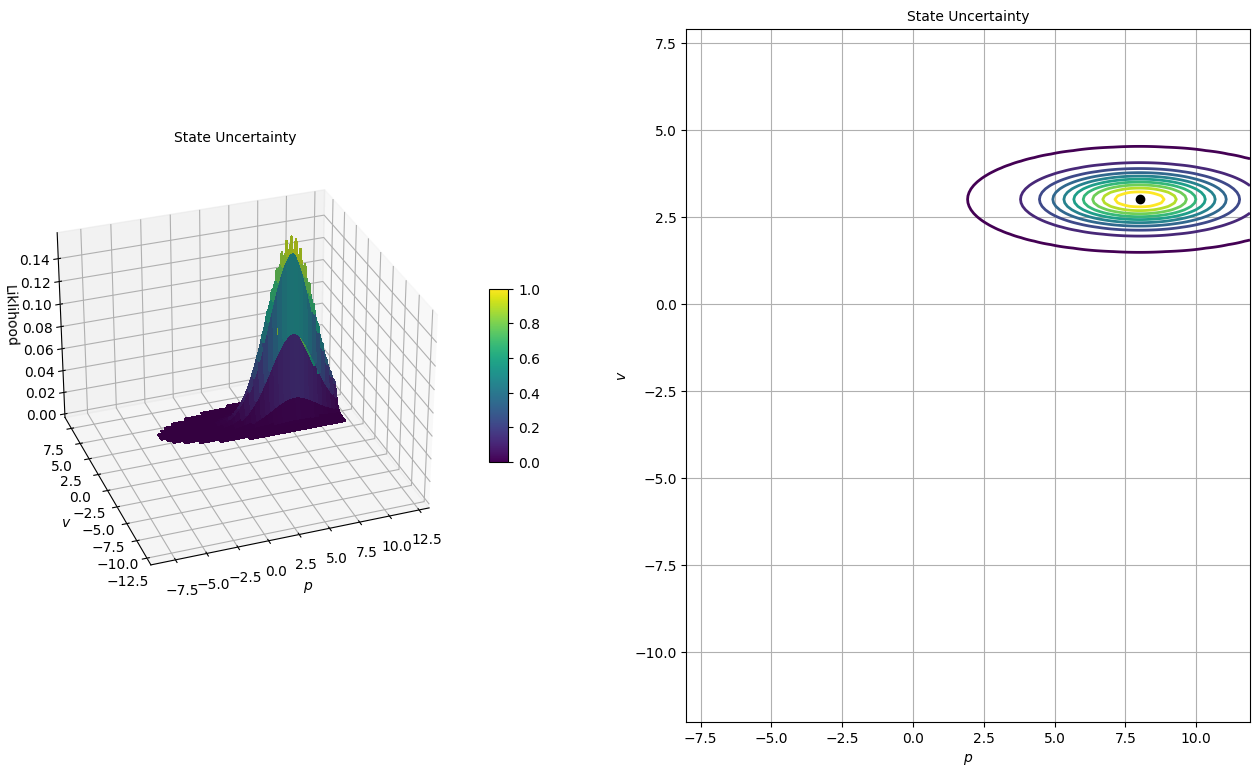

In [4]:
# Show solution paths in a surface plot
x = np.arange(-1*x0[0], 1.5*x0[0], 0.1)
y = np.arange(-1.5*x0[0], 1*x0[0], 0.1)
X, Y = np.meshgrid(x, y)
Z = gaus2d([X, Y], x0, Q0)

CP = np.arange(np.max(Z)/100, np.max(Z), np.max(Z)/10) # colors

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(16,9))
#===============
#  First subplot
#===============
ax = fig.add_subplot(121, projection='3d')
ax.set_title('State Uncertainty')
ax.azim = -110
ax.dist = 10
ax.elev = 30
ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$v$")
ax.set_zlabel(r"Liklihood")

# plot the figure
# create a color mapping manually
Zmin = np.max(Z)/1e7  #threshold
Zmax = np.max(Z)  #threshold
cmap = get_cmap('viridis')
colors = cmap((Z - Zmin)/(Zmax - Zmin))
colors[(Z < Zmin) | (Z > Zmax), -1] = 0

surf = ax.plot_surface(X, Y, Z, facecolors=colors,linewidth=1, antialiased=False,)
plt.grid(False)
fig.colorbar(surf, shrink=0.25, aspect=9)
#plt.plot(x0[0],x0[1],x0[1],'ko',label='x')

#===============
# Second subplot
#===============
ax2 = fig.add_subplot(122)
cp = ax2.contour(X, Y, Z, CP)
ax2.set_title('State Uncertainty')
ax2.set_xlabel(r"$p$")
ax2.set_ylabel(r"$v$")
plt.plot(x0[0],x0[1], 'ko',label='x')
plt.tight_layout
plt.show()

## Discrete Covariance Propagation

Steady state Q


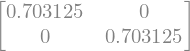

Iterated Steady state Q


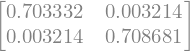

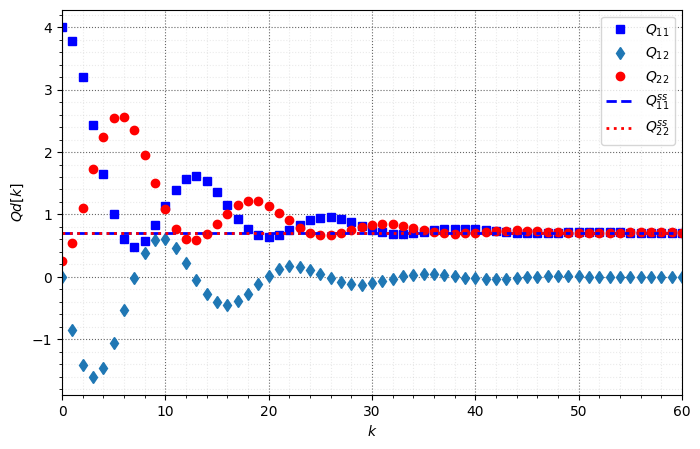

In [5]:
# Steady State value (see Lecture 7)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_discrete_lyapunov.html#scipy.linalg.solve_discrete_lyapunov
Qdss = solve_discrete_lyapunov(Ad, Wd)
print("Steady state Q")
display(Matrix(np.round(Qdss,6)))

# Discrete Prop (see Lecture 7) and sim
Qd = np.zeros((Nx,Nx,N+1))
Qd[:,:,0] = Q0
Xd = np.zeros((Nx,1,N+1))
Xd[:,:,0] = np.vstack(x0)
Xs = np.zeros((Nx,1,N+1))
Xs[:,:,0] = np.vstack(x0)+sqrtm(Q0)@np.vstack(randn(2)) # random initial pt
for k in np.arange(1,N+1,1):
    Qd[:,:,k] = Ad@Qd[:,:,k-1]@Ad.T+Wd
    Xd[:,:,k] = Ad@Xd[:,:,k-1]
    Xs[:,:,k] = Ad@Xs[:,:,k-1] + sWd@np.vstack(randn(2))
print("Iterated Steady state Q")
display(Matrix(np.round(Qd[:,:,-1],6)))

KK=np.arange(N+1)
plt.figure(3,figsize=(8,5))
ax1 = plt.subplot(1, 1, 1)
ax1.plot(KK,Qd[0,0,:],'bs',label=r'$Q_{11}$')
ax1.plot(KK,Qd[0,1,:],'d',label=r'$Q_{12}$')
ax1.plot(KK,Qd[1,1,:],'ro',label=r'$Q_{22}$')
ax1.plot([0,N],[Qdss[0,0],Qdss[0,0]],'b--',label=r'$Q^{ss}_{11}$')
ax1.plot([0,N],[Qdss[1,1],Qdss[1,1]],'r:',label=r'$Q^{ss}_{22}$')
plt.ylabel(r'$Qd[k]$')
plt.xlabel(r'$k$')
plt.xlim([0, N])
nicegrid()
plt.legend(loc='best')
plt.show()

## Plot state uncertainty as function of time

In [6]:
x = np.arange(-1.5*x0[0], 1.5*x0[0], 0.1)
X, Y = np.meshgrid(x, x)

ZZ = 0.3 # scaling in color map
CP = np.arange(ZZ/100, ZZ, ZZ/10)
Nskip = 4 # don't show all points in time or else too busy
def f(Nprop = Nskip):
    fig = plt.figure(6,figsize=(8,5)) 
    for k in np.arange(int(Nskip*np.floor(Nprop/Nskip))+1):
        plt.plot(Xd[0,0,k],Xd[1,0,k], 'ro',label='$\bar x$')
        plt.plot(Xs[0,0,k],Xs[1,0,k], 'b.',label='$x$')
        if k % Nskip == 0:
            Z = gaus2d([X, Y], Xd[:,:,k], Qd[:,:,k])
            cp = plt.contour(X, Y, Z, CP)
    plt.xlabel(r"$p$")
    plt.ylabel(r"$v$")
    plt.title('Propagation of Uncertainty')
    plt.show()

interactive_plot = interactive(f, {'manual': False}, Nprop=(0, N, Nskip))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=4, description='Nprop', max=60, step=4), Output()), _dom_classes=('widge…

## Continuous Covariance Propagation

* Covariance propagation given by the matrix differential equation
\begin{equation}
\dot{Q}(t) = AQ(t)+Q(t)A^T+B_wW_cB_w^T
\end{equation}
* $AQ(t)+Q(t)A^T$ -- Homogeneous part -- contractive for stable
  $A$, $\njar$ reduces covariance
* $B_wW_cB_w^T$ -- Impact of process noise part, which increases covariance

 Steady state solution must balance these two effects
* For a system with constant dynamics $(A,B_w,W_c)$ and a stable
  $A$, a steady state solution exists and is given by the solution $Q_{ss}$ of
  the *Lyapunov Equation*
\begin{equation}
AQ_{ss}+Q_{ss}A^T+B_wW_cB_w^T=0 
\end{equation}


Integrated cts Steady state Q


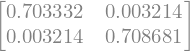

Computed cts Steady state Q


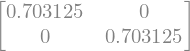

interactive(children=(IntSlider(value=0, description='disc_toggle', max=1), Output()), _dom_classes=('widget-i…

In [7]:
Npts = 50*N # denser time spacer for cts time integration
tf = N*dt
t = np.linspace(0,tf,Npts)

def doty(y, t, A, B, W, n):
    Q = y.reshape(n,n)
    dotQ = A@Q + Q@A.T + B@np.atleast_2d(W)@B.T
    return dotQ.reshape(2*n,)
    
# integrate Q
Qsol = odeint(doty, Q0.reshape(2*Nx,), t, args=(A, Bw, Wc, Nx))
# steady state Q
Qcss = la.solve_continuous_lyapunov(A, -Bw@np.atleast_2d(Wc)@Bw.T) # note - here

def fcov(disc_toggle = 0):
    f, axs = plt.subplots(3, 1, sharex=True, figsize=(8,5))
    axs[0].plot(t, Qsol[:, 0], 'b', label=r'$Q_{11}$')
    axs[1].plot(t, Qsol[:, 1], 'g', label=r'$Q_{12}$')
    axs[2].plot(t, Qsol[:, 3], 'r', label=r'$Q_{22}$')
    axs[0].plot([tf*.75,tf],[Qcss[0,0],Qcss[0,0]],'bs',label=r'$Q^{ss}_{11}$')
    axs[1].plot([tf*.75,tf],[Qcss[0,1],Qcss[0,1]],'gs',label=r'$Q^{ss}_{12}$')
    axs[2].plot([tf*.75,tf],[Qcss[1,1],Qcss[1,1]],'rs',label=r'$Q^{ss}_{22}$')
    for ll in range(len(axs)):
        axs[ll].legend(loc='best')
        axs[ll].set_ylim([-2,5])
        nicegrid(axs[ll])
    plt.xlim([0,tf])
    plt.xlabel(r'Time (s)')

    axs[0].text(tf/2,4,r'$Q_{ss} = $'+str(round(Qcss[0,0],4)))
    axs[2].text(tf/2,4,r'$Q_{ss} = $'+str(round(Qcss[1,1],4)))

    if (disc_toggle == 1):
        axs[0].set_title('Comparison of Discrete and Cts Covariance Propagation')
        axs[0].text(tf/2,3,r'$Qd_{ss} = $'+str(round(Qdss[0,0],4)))
        axs[2].text(tf/2,3,r'$Qd_{ss} = $'+str(round(Qdss[1,1],4)))
        axs[0].plot(KK*dt,Qd[0,0,:],'b.',label=r'$Q_{11}$')
        axs[1].plot(KK*dt,Qd[0,1,:],'d',label=r'$Q_{12}$')
        axs[2].plot(KK*dt,Qd[1,1,:],'ro',label=r'$Q_{22}$')
        axs[0].plot([0,N*dt],[Qdss[0,0],Qdss[0,0]],'k--',label=r'$Q^{ss}_{11}$')
        axs[2].plot([0,N*dt],[Qdss[1,1],Qdss[1,1]],'k--',label=r'$Q^{ss}_{22}$')
    else:
        axs[0].set_title('Cts Covariance Propagation')
    plt.show()

print("Integrated cts Steady state Q")
display(Matrix(np.round(Qsol[-1,:].reshape(2,2),6)))
print("Computed cts Steady state Q")
display(Matrix(np.round(Qcss,6)))

interactive_plot = interactive(fcov, {'manual': False}, disc_toggle=(0, 1, 1))
interactive_plot

## Simulation: Analyze possible state values

In [8]:
# Discrete Prop (see Lecture 7) and sim
Qd = np.zeros((Nx,Nx,N+1))
Qd[:,:,0] = Q0
Xd = np.zeros((Nx,1,N+1))
Xd[:,:,0] = np.vstack(x0)

Ns = 20 # number of simulated states to simulate
Xs = np.zeros((Nx,1,N+1,Ns))
CC = ['b','g','k','c','y','m']
for jj in np.arange(0,Ns,1):
    Xs[:,:,0,jj] = np.vstack(x0)+sqrtm(Q0)@np.vstack(randn(2)) # random initial pt
for k in np.arange(1,N+1,1):
    Qd[:,:,k] = Ad@Qd[:,:,k-1]@Ad.T+Wd
    Xd[:,:,k] = Ad@Xd[:,:,k-1]
    for jj in np.arange(0,Ns,1):
        Xs[:,:,k,jj] = Ad@Xs[:,:,k-1,jj] + sWd@np.vstack(randn(2))

def f(Nlim=2):
    fig = plt.figure(6,figsize=(8, 8)) 
    for k in np.arange(np.max([0,Nlim-2*Nskip]),Nlim+1,1):
        plt.plot(Xd[0,0,k],Xd[1,0,k], 'ro',label='$\bar x$')
        if k%Nskip == 0:
            Z = gaus2d([X, Y], Xd[:,:,k], Qd[:,:,k])
            cp = plt.contour(X, Y, Z, CP)            
    for jj in np.arange(0,Ns,1):
        for k in np.arange(np.max([0,Nlim-2*Nskip]),Nlim+1,1):
            plt.plot(Xs[0,0,k,jj],Xs[1,0,k,jj], '.',c=CC[np.mod(k,6)])
    plt.xlabel(r"$p$")
    plt.ylabel(r"$v$")
    plt.title('Prop of uncertainty')
    plt.show()

interactive_plot = interactive(f, {'manual': False}, Nlim=(0, 20, 1))
output = interactive_plot.children[-1]
interactive_plot


interactive(children=(IntSlider(value=2, description='Nlim', max=20), Output()), _dom_classes=('widget-interac…

$\newcommand{\njbxh}{\widehat{\mathbf{x}}}
\newcommand{\njbxt}{\tilde{\mathbf{x}}}
\newcommand{\njbxhn}{\hat{\mathbf{x}}}
\newcommand{\njbyh}{\widehat{\mathbf{y}}}
\newcommand{\njbu}{\mathbf{u}}
\newcommand{\njbf}{\mathbf{f}}
\newcommand{\njbg}{\mathbf{g}}
\newcommand{\njbh}{\mathbf{h}}
\newcommand{\njba}{\mathbf{a}}
\newcommand{\njbb}{\mathbf{b}}
\newcommand{\njbi}{\mathbf{i}}
\newcommand{\njbe}{\mathbf{e}}
\newcommand{\njbd}{\mathbf{d}}
\newcommand{\njbp}{\mathbf{p}}
\newcommand{\njbq}{\mathbf{q}}
\newcommand{\njbr}{\mathbf{r}}
\newcommand{\njby}{\mathbf{y}}
\newcommand{\njbv}{\mathbf{v}}
\newcommand{\njbw}{\mathbf{w}}
\newcommand{\njbx}{\mathbf{x}}
\newcommand{\njbX}{\mathbf{X}}
\newcommand{\njbY}{\mathbf{Y}}
\newcommand{\njbz}{\mathbf{z}}
\newcommand{\njbs}{\mathbf{s}}
\newcommand{\njbm}{\mathbf{m}}
\newcommand{\njbn}{\mathbf{n}}
\newcommand{\njbc}{\mathbf{C}}
\newcommand{\bt}{\begin{tabular}}
\newcommand{\et}{\end{tabular}}
\newcommand{\bq}{\begin{quote}}
\newcommand{\eq}{\end{quote}}
\newcommand{\bi}{\begin{itemize}}
\newcommand{\ei}{\end{itemize}}
\newcommand{\bee}{\begin{enumerate}}
\newcommand{\eee}{\end{enumerate}}
\newcommand{\bea}{\begin{eqnarray}}
\newcommand{\eea}{\end{eqnarray}}
\newcommand{\beas}{\begin{eqnarray*}}
\newcommand{\eeas}{\end{eqnarray*}}
\newcommand{\ba}{\begin{array}}
\newcommand{\ea}{\end{array}}
\newcommand{\jbas}{\begin{align*}}
\newcommand{\jeas}{\end{align*}}
\newcommand{\bff}{\begin{flushleft}}
\newcommand{\eff}{\end{flushleft}}
\newcommand{\bc}{\begin{center}}
\newcommand{\ec}{\end{center}}
\newcommand{\simn}{\stackrel{\min}{\sim}}
\newcommand{\njar}{\Rightarrow}$

# Transforming $\cal N(0,1)$ to something more useful
## Application: Simulating Noise
How use *randn* to simulate non-zero mean Gaussian noise with
  covariance $Q$? 

*   Note that $\njbw\sim\mathcal{N}(\overline \njbw,Q)$, but
$\njbz\sim\mathcal{N}(0,I)$

*   Given transformation rules, try
$\njbw=\overline\njbw+V\njbz$ but what is $V$?.

* From $Q=Q^T$, can use *sqrtm* to get $Q=SS$, with $S=S^T$ 
or use *chol* to get $Q=N^TN$

* With noise weighting $\njbw\sim\mathcal{N}(0,Q)$, can use 
$$
\left. \ba{l}
\njbw = S \njbz\\
S={\tt sqrtm}(Q)
\ea \right\} \njar E[\njbw\njbw^T]=SE[\njbz\njbz^T]S^T=SS^T=Q
$$

* Or
$$
\left. \ba{l}
\njbw = N^T \njbz\\
N={\tt chol}(Q)
\ea \right\} \njar E[\njbw\njbw^T]=N^TE[\njbz\njbz^T]N=N^TN=Q
$$

* Can show that $S=N^TT$, $T^TT=I$ so $SS^T=(N^TT)(T^TN)=N^TN$


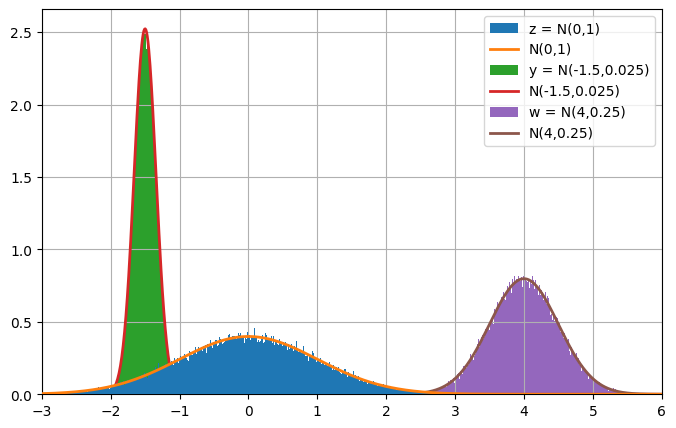

In [9]:
from numpy.random import multivariate_normal, randn

NN = 100000 # number of pts 
dx = 0.01 # bin size
z = randn(NN,1) # N(0,1)
x = np.linspace(-4,6,int(10/dx))

wbar = np.array(4)
Q = np.array(0.25);
w = wbar + sqrt(Q)*z

ybar = np.array(-1.5)
Qy = np.array(0.025);
y = ybar + sqrt(Qy)*z

plt.figure(7,figsize=(8,5))
plt.hist(z, bins=np.arange(-4,4,dx),density=True,label='z = N(0,1)',zorder=5) 
plt.plot(x,exp(-x**2/(2*1))/(np.sqrt(2*np.pi*1)),label='N(0,1)',zorder=6)

plt.hist(y, bins=np.arange(-4+ybar,4+ybar,dx),density=True,label='y = N(-1.5,0.025)') 
plt.plot(x,exp(-(x-ybar)**2/(2*Qy))/(np.sqrt(2*np.pi*Qy)),label='N(-1.5,0.025)')

plt.hist(w, bins=np.arange(-4+wbar,4+wbar,dx),density=True,label='w = N(4,0.25)') 
plt.plot(x,exp(-(x-wbar)**2/(2*Q))/(np.sqrt(2*np.pi*Q)),label='N(4,0.25)')

plt.legend()
plt.xlim(-3,6)
plt.show()

## 2D version

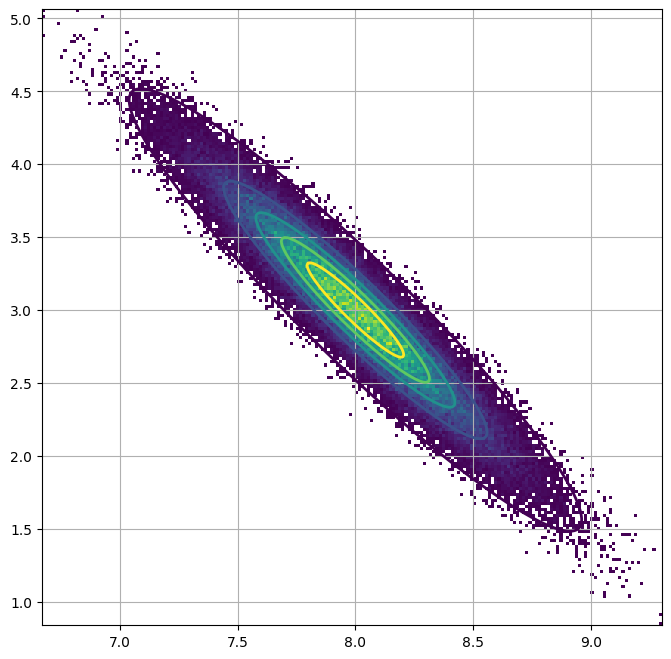

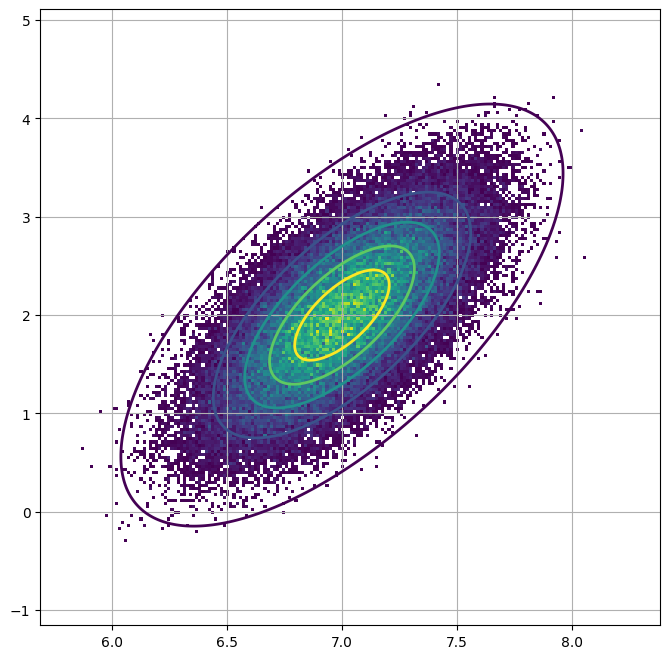

In [10]:
# Fixing random state for reproducibility.
np.random.seed(19680801)

def plot_compare(zbar,Wd):
    Wd = (Wd + Wd.T)/2 # make it symmetric
    sWd = sqrtm(Wd)

    data = np.vstack([multivariate_normal(zbar, Wd, size=100000)])

    # Show solution paths in a surface plot
    x2d = np.arange(0, 16, 0.01)
    y2d = np.arange(-1, 5, 0.01)
    X2d, Y2d = np.meshgrid(x2d, y2d)
    Z2d = gaus2d([X2d, Y2d], zbar, Wd)
    CP2d = np.arange(np.max(Z2d)/100, np.max(Z2d), np.max(Z2d)/5) # colors

    fig, axs = plt.subplots(nrows=1, ncols=1,figsize=(8,8))
    axs.hist2d(data[:, 0], data[:, 1], bins=200, density=True, cmin = 0.025)
    cp = axs.contour(X2d, Y2d, Z2d, CP2d)
    plt.show()
    
# two cases
zbar = np.array([8, 3])
Wd = np.array([[.1, -.3],[0, .25]])
plot_compare(zbar,Wd)

zbar = np.array([7, 2])
Wd = np.array([[.1, .3],[0, .5]])
plot_compare(zbar,Wd)
